In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.init as init
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset definition
class PairedDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images_per_category=None):
        self.root_dir = root_dir
        self.transform = transform
        self.categories = ['Earthquake', 'Hurricane', 'Landslides', 'Flood', 'Wildfire']
        self.filenames = {}
        for cat in self.categories:
            files = os.listdir(os.path.join(root_dir, cat))
            if max_images_per_category is not None:
                files = files[:max_images_per_category]
            self.filenames[cat] = files

    def __len__(self):
        return sum([len(self.filenames[cat]) for cat in self.categories])

    def __getitem__(self, idx):
        for cat in self.categories:
            if idx < len(self.filenames[cat]):
                image_name = self.filenames[cat][idx]
                break
            idx -= len(self.filenames[cat])
        img_path = os.path.join(self.root_dir, cat, image_name)
        paired_path = os.path.join(self.root_dir, f"{cat}_paired", image_name)

        img = Image.open(img_path).convert('RGB')
        paired_img = Image.open(paired_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
            paired_img = self.transform(paired_img)

        return paired_img, img
    

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)]),
])

#train_dataset = PairedDataset('./train+val/train', transform=transform,max_images_per_category=100)
train_dataset = PairedDataset('./train+val/train', transform=transform)
val_dataset = PairedDataset('./train+val/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [5]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, cond):
        combined = torch.cat([img, cond], 1)
        return self.main(combined)


In [6]:
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            init.constant_(m.bias.data, 0.0)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
# Assuming G and D are your Generator and Discriminator models
G.apply(weights_init_xavier)
D.apply(weights_init_xavier)

print(G)
print(D)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [14]:
criterion = nn.BCELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

epochs = 6
real_label = 1
fake_label = 0

In [15]:
# Now define your scheduler (example with StepLR)
scheduler_G = StepLR(optimizer_G, step_size=8, gamma=0.7)
scheduler_D = StepLR(optimizer_D, step_size=10, gamma=0.8)

In [16]:
# Path to save the checkpoints
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Function to save a checkpoint
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, os.path.join(checkpoint_dir, filename))

# Function to load a checkpoint
def load_checkpoint(filename="checkpoint.pth.tar"):
    return torch.load(os.path.join(checkpoint_dir, filename))

In [17]:
batch_size = 4

def display_images(original, corrupted, generated):
    """
    Display original, corrupted, and generated images side by side.
    Assumes all image tensors are of shape (batch, channels, height, width).
    """
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, batch_size * 5))
    for i in range(batch_size):
        axes[i, 0].imshow(original[i].permute(1, 2, 0).detach().cpu())
        axes[i, 1].imshow(corrupted[i].permute(1, 2, 0).detach().cpu())
        axes[i, 2].imshow(generated[i].permute(1, 2, 0).detach().cpu())

        axes[i, 0].set_title('Original')
        axes[i, 1].set_title('Corrupted')
        axes[i, 2].set_title('Generated')
        
        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Example usage after backpropagation:
gradient_norm = get_gradient_norm(G)  # For the generator
print(f"Generator Gradient Norm: {gradient_norm}")



Generator Gradient Norm: 0.0


Epoch [0/6], Step [0/86], Discriminator Gradient Norm: 1.771585414699519
Generator Gradient Norm: 136.97297991253438
Epoch 1/6 - Loss D: 0.0160, Loss G: 6.3813
G 1.4123762449999997e-05 D5.3687091200000036e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


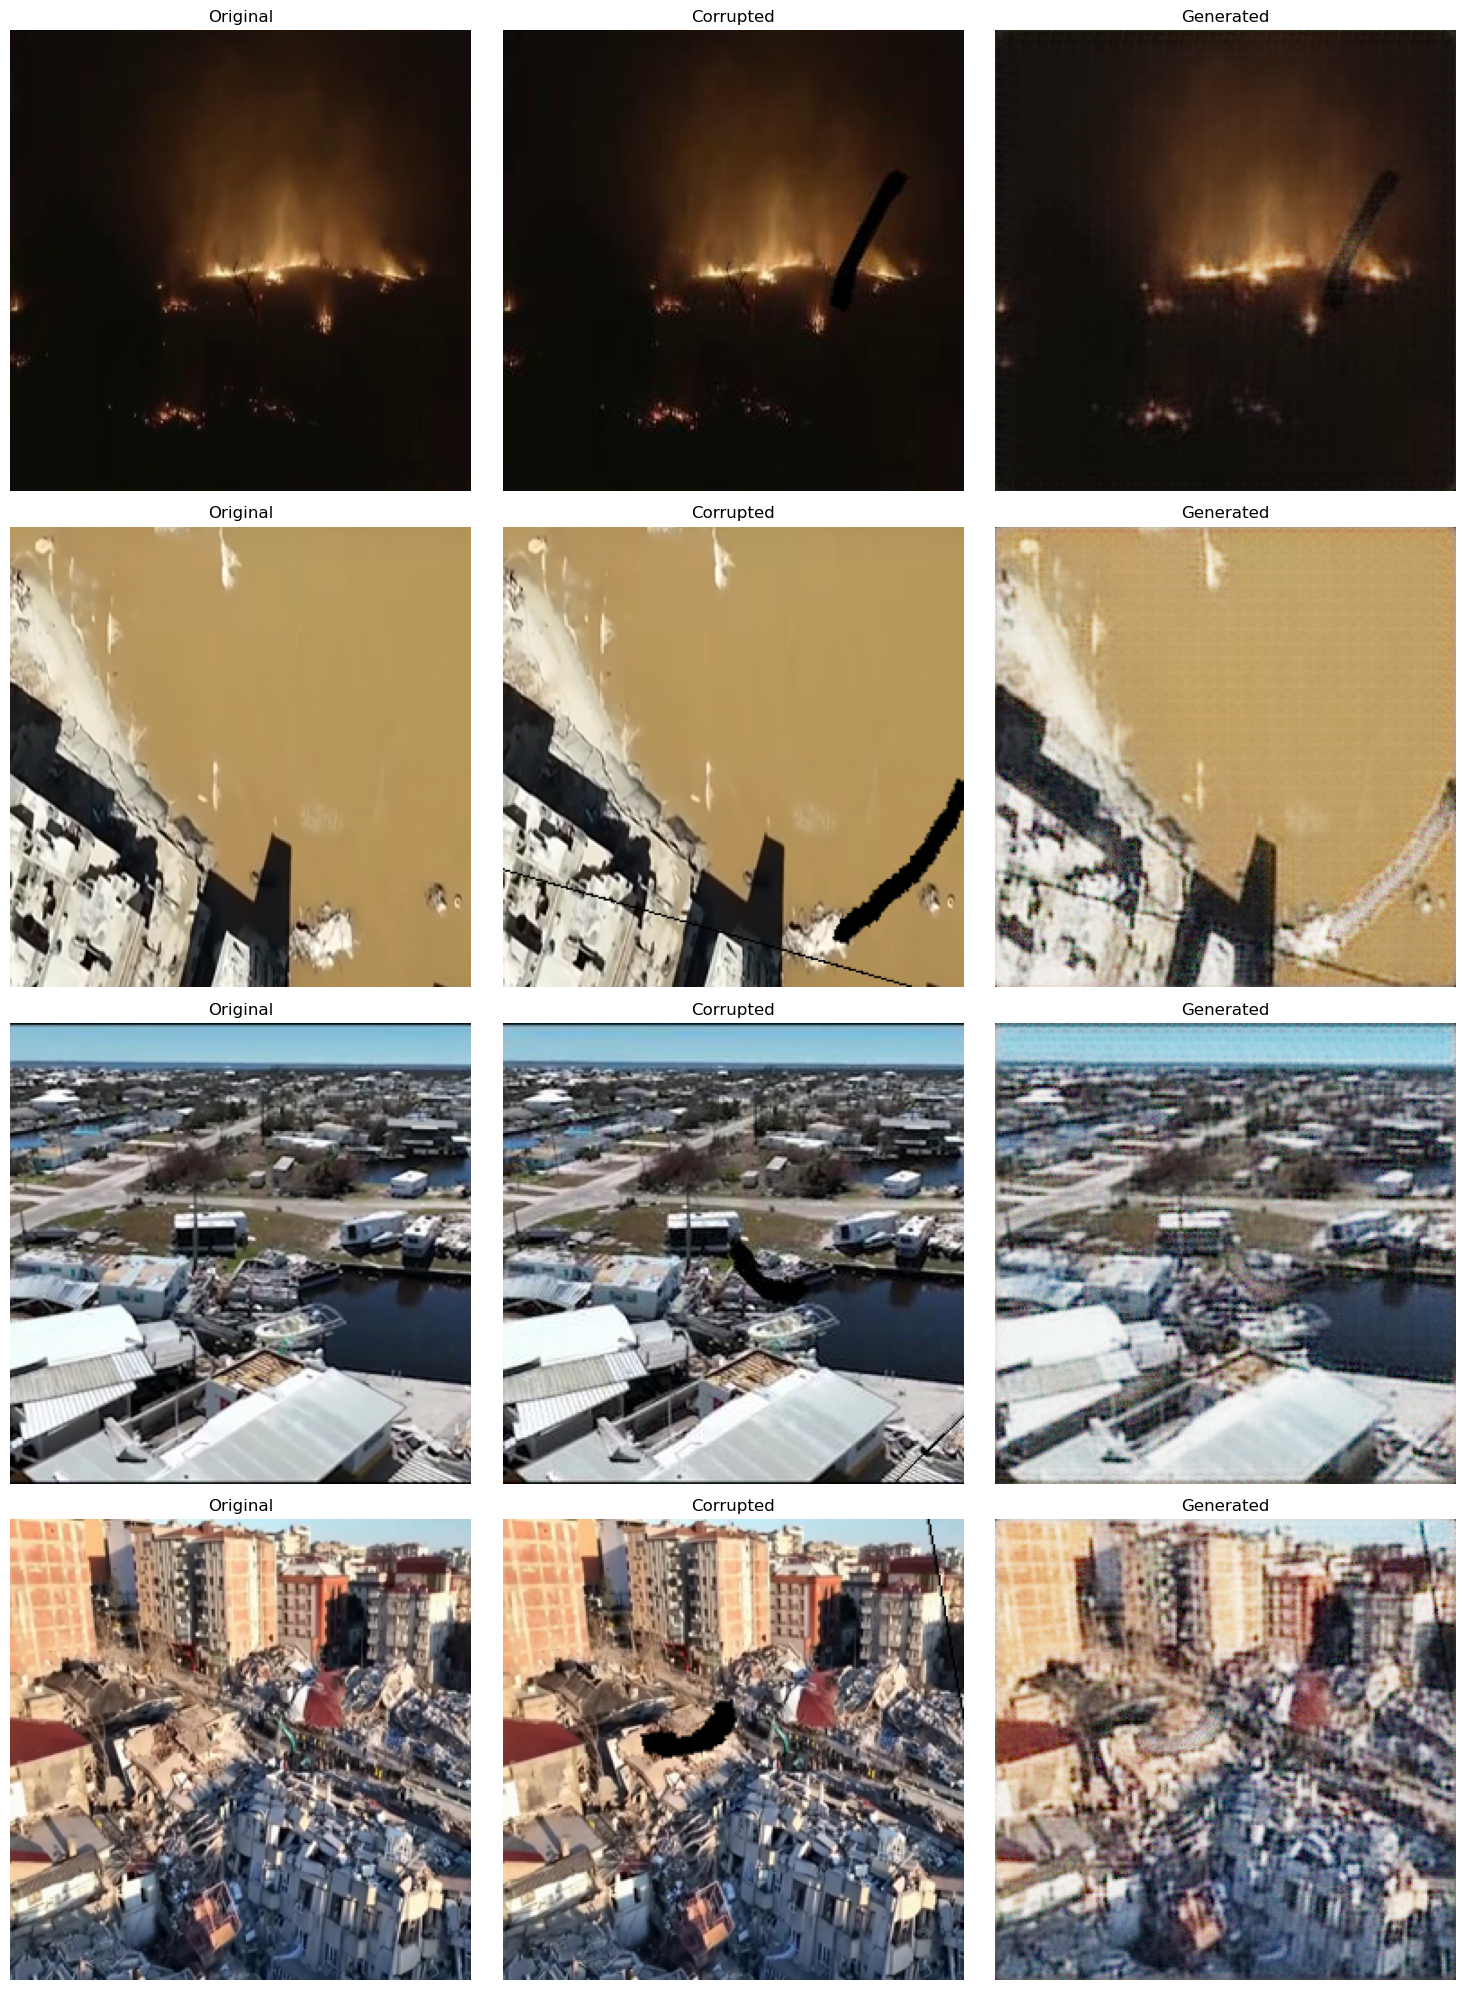

Epoch [0/6], Step [1/86], Discriminator Gradient Norm: 0.4083089919897139
Generator Gradient Norm: 63.547877282210685
Epoch [0/6], Step [2/86], Discriminator Gradient Norm: 0.5418188338633744
Generator Gradient Norm: 55.952493581445026
Epoch [0/6], Step [3/86], Discriminator Gradient Norm: 0.8725234266877203
Generator Gradient Norm: 54.012555028768226
Epoch [0/6], Step [4/86], Discriminator Gradient Norm: 1.087806965402607
Generator Gradient Norm: 73.99018997617686
Epoch [0/6], Step [5/86], Discriminator Gradient Norm: 1.4693229702607427
Generator Gradient Norm: 107.96736597275714
Epoch [0/6], Step [6/86], Discriminator Gradient Norm: 1.4844684724769663
Generator Gradient Norm: 44.17160449445391
Epoch [0/6], Step [7/86], Discriminator Gradient Norm: 0.285725381165759
Generator Gradient Norm: 73.60331623552655
Epoch [0/6], Step [8/86], Discriminator Gradient Norm: 0.21132284395106826
Generator Gradient Norm: 81.66860239451842
Epoch [0/6], Step [9/86], Discriminator Gradient Norm: 0.5665

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [22]:

#Train Loop
for epoch in range(epochs):
    for i ,(corrupted_imgs, original_imgs) in enumerate(train_loader):
        corrupted_imgs, original_imgs = corrupted_imgs.to(device), original_imgs.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        output_real = D(original_imgs, corrupted_imgs)
        real_labels = torch.full(output_real.shape, real_label, device=device).float()
        loss_real = criterion(output_real, real_labels)
        
        fake_imgs = G(corrupted_imgs)
        output_fake = D(fake_imgs.detach(), corrupted_imgs)
        fake_labels = torch.full(output_fake.shape, fake_label, device=device).float()
        loss_fake = criterion(output_fake, fake_labels)
        
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        #torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=20)
        optimizer_D.step()
        gradient_norm_D = get_gradient_norm(D)
        print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Discriminator Gradient Norm: {gradient_norm_D}")
        
        # Train Generator
        optimizer_G.zero_grad()
        
        output_fake = D(fake_imgs, corrupted_imgs)
        loss_GAN = criterion(output_fake, real_labels)  # we want the Generator to generate images that the Discriminator thinks are real
        loss_L1 = criterion_L1(fake_imgs, original_imgs)
        
        loss_G = loss_GAN + 10 * loss_L1
        loss_G.backward()
        #itorch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=35)
        optimizer_G.step()

        gradient_norm = get_gradient_norm(G)  # For the generator
        print(f"Generator Gradient Norm: {gradient_norm}")
       
        
        if (i) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
            print("G " +str(optimizer_G.param_groups[0]['lr']) +" D"+str(optimizer_D.param_groups[0]['lr']))
            with torch.no_grad():
                for corrupted_imgs, original_imgs in train_loader:
                    corrupted_imgs, original_imgs = corrupted_imgs.to(device), original_imgs.to(device)
                    generated_imgs = G(corrupted_imgs)
                    display_images(original_imgs, corrupted_imgs, generated_imgs)
                    break
        # You can print the loss values here if needed
            scheduler_D.step()
            scheduler_G.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    # save_checkpoint({
    #     'epoch': epoch + 1,
    #     'G_state_dict': G.state_dict(),
    #     'D_state_dict': D.state_dict(),
    #     'optimizer_G_state_dict': optimizer_G.state_dict(),
    #     'optimizer_D_state_dict': optimizer_D.state_dict(),
    # })

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


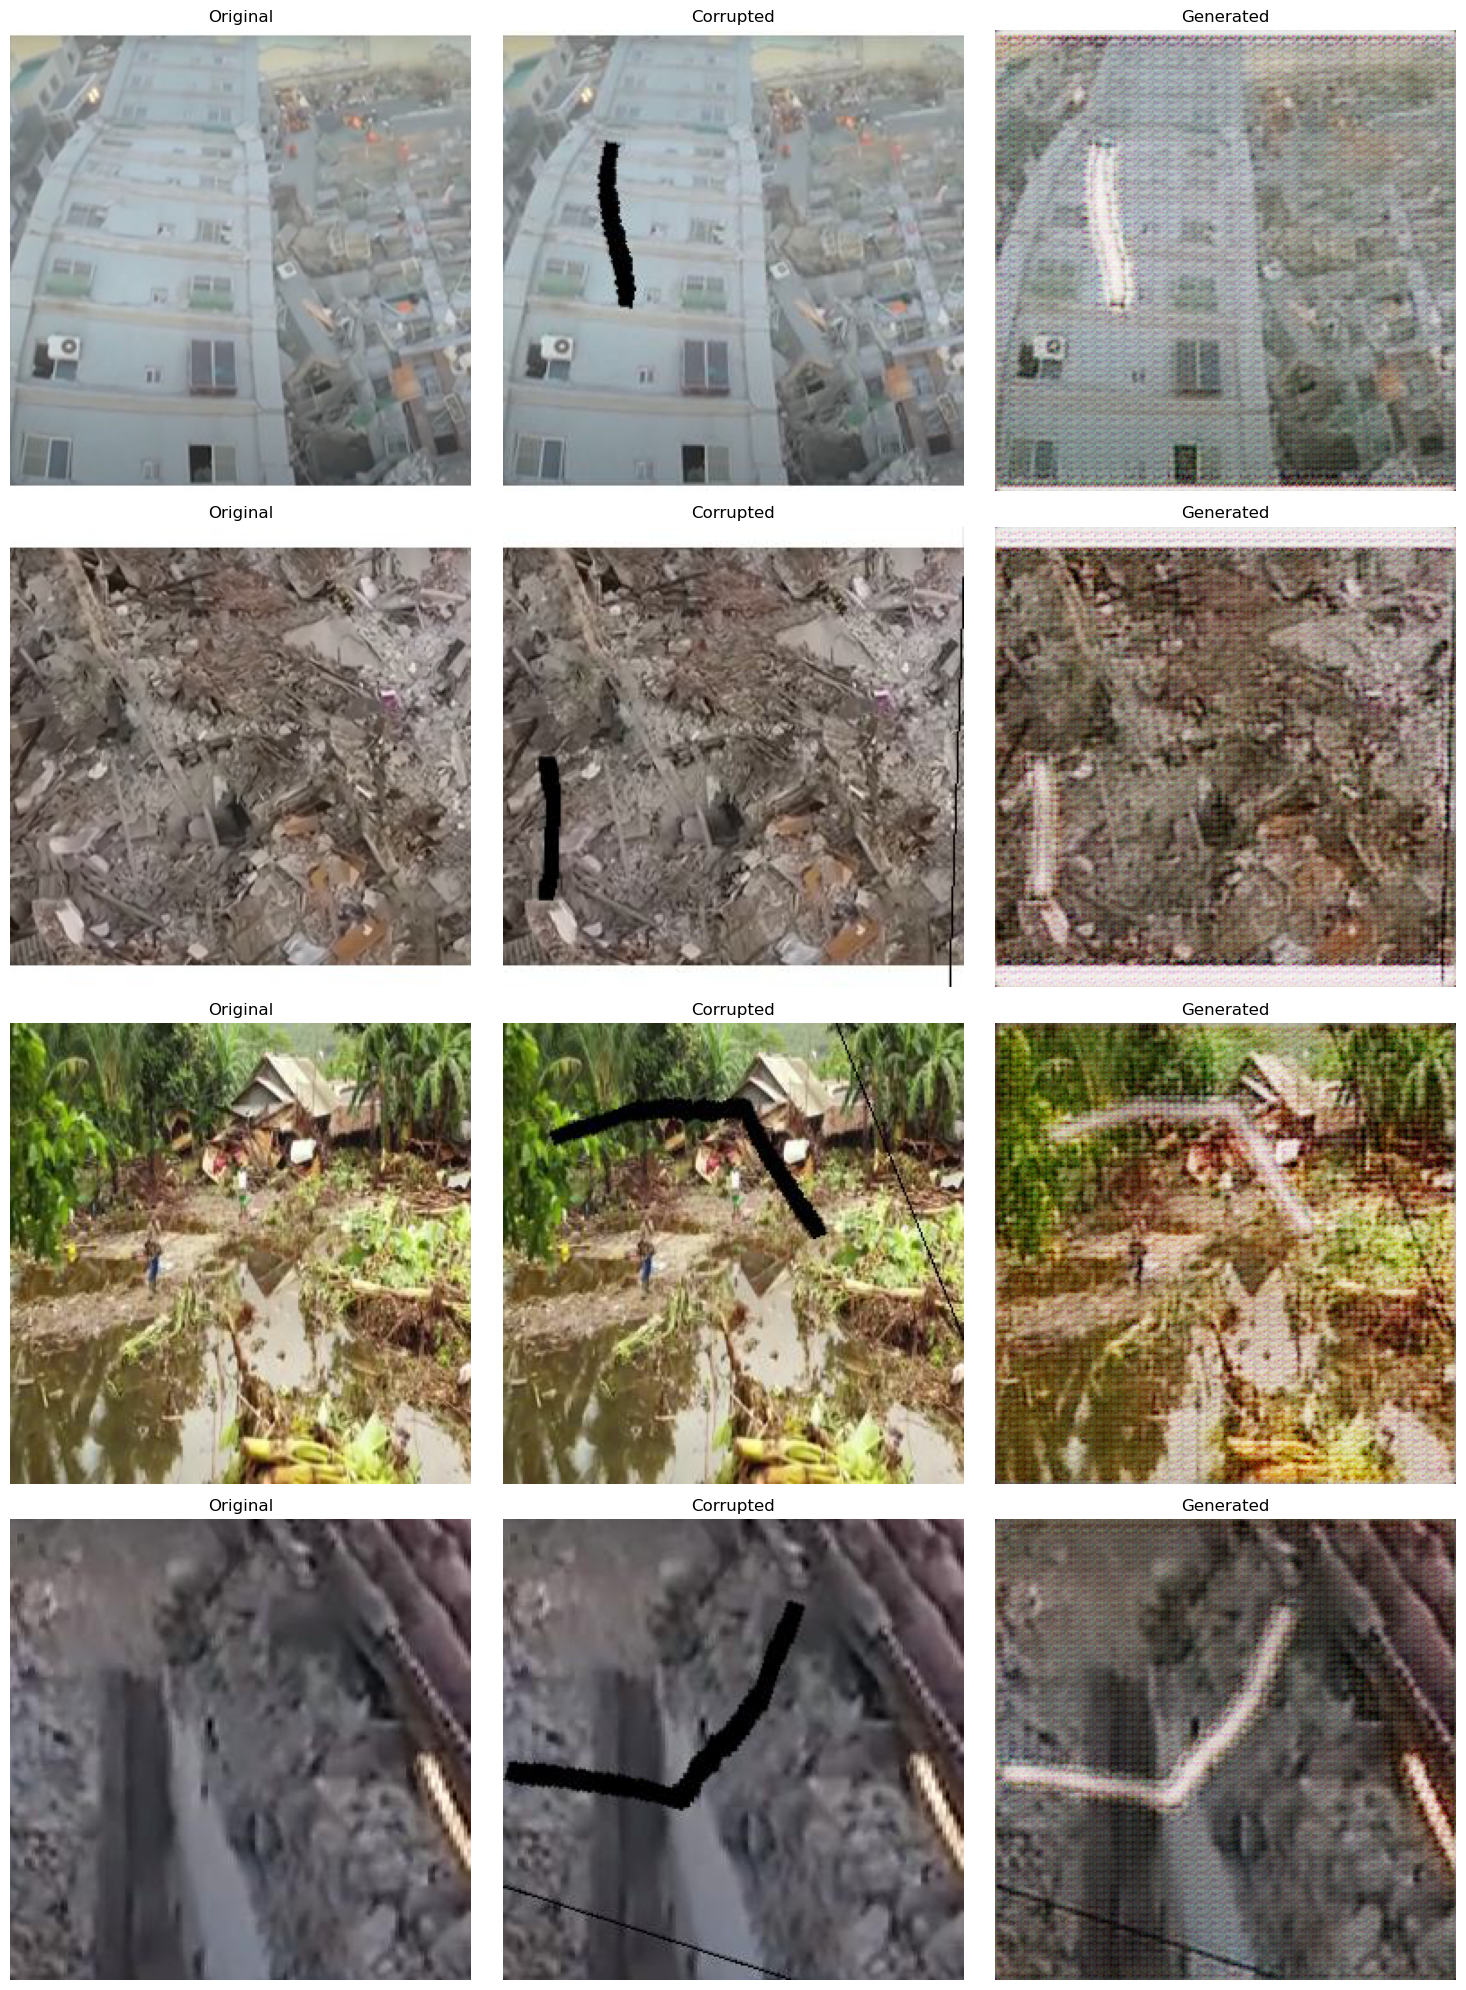

In [20]:
with torch.no_grad():
 for corrupted_imgs, original_imgs in val_loader:
    corrupted_imgs, original_imgs = corrupted_imgs.to(device), original_imgs.to(device)
    generated_imgs = G(corrupted_imgs)
    display_images(original_imgs, corrupted_imgs, generated_imgs)
    break

In [74]:
# Validation loop with SSIM and PSNR
G.eval()  # Set the generator to evaluation mode
D.eval()  # Set the discriminator to evaluation mode
ssim_scores = []
psnr_scores = []

# No need to apply gradients when doing validation
with torch.no_grad():
    for corrupted_imgs_batch, original_imgs_batch in val_loader:
        # Generate images with the cGAN
        generated_imgs_batch = G(corrupted_imgs_batch).detach()
        # Loop over each image in the batch
        for i in range(corrupted_imgs_batch.size(0)):
            # Extract the individual images from the batch
            gen_img = generated_imgs_batch[i].cpu().numpy()
            orig_img = original_imgs_batch[i].cpu().numpy()
            # Convert the images to the correct format (H x W x C) and range [0, 255]
            gen_img = np.transpose(gen_img, (1, 2, 0)) * 255.0
            orig_img = np.transpose(orig_img, (1, 2, 0)) * 255.0
            gen_img = gen_img.astype(np.uint8)
            orig_img = orig_img.astype(np.uint8)
            # Calculate SSIM and PSNR for the individual images
            ssim_score = ssim(orig_img, gen_img, data_range=255, multichannel=True, channel_axis=-1)
            psnr_score = psnr(orig_img, gen_img, data_range=255)
            # Append the scores to the lists
            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)

# Calculate the mean SSIM and PSNR across all images in the validation set
mean_ssim = np.mean(ssim_scores)
mean_psnr = np.mean(psnr_scores)

print(f"Mean SSIM: {mean_ssim:.4f}")
print(f"Mean PSNR: {mean_psnr:.4f}")


Mean SSIM: 0.7578
Mean PSNR: 23.5201


In [44]:
print("SSIM max :" + str(max(ssim_scores))+" min: "+str(min(ssim_scores)))
print("PSNR max :" + str(max(psnr_scores))+" min: "+str(min(psnr_scores)))

SSIM max :0.9161217115043975 min: 0.11409667451692189
PSNR max :33.97420237282005 min: 7.676622956090895


In [21]:
# Load the checkpoint
checkpoint = load_checkpoint()

#Load the Generator and Discriminator states
G.load_state_dict(checkpoint['G_state_dict'])
D.load_state_dict(checkpoint['D_state_dict'])

# Load the Optimizer states
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

# Load the epoch
epoch = checkpoint['epoch']

In [ ]:
# save_checkpoint({
#         'epoch': epoch + 1,
#         'G_state_dict': G.state_dict(),
#         'D_state_dict': D.state_dict(),
#         'optimizer_G_state_dict': optimizer_G.state_dict(),
#         'optimizer_D_state_dict': optimizer_D.state_dict(),
#     })

In [ ]:
print(G.state_dict())

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
        
# Dataset definition
class PairedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.categories = ['Earthquake', 'Hurricane', 'Landslides', 'Flood', 'Wildfire']
        self.label_map = {category: i for i, category in enumerate(self.categories)}
        self.image_names = []
        self.labels = []

        for category in self.categories:
            category_dir = os.path.join(root_dir, category)
            images = os.listdir(category_dir)
            self.image_names.extend([os.path.join(category, img) for img in images])
            self.labels.extend([self.label_map[category]] * len(images))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dataset and dataloaders
train_dataset = PairedDataset(root_dir='./train+val/train', transform=transform)
val_dataset = PairedDataset(root_dir='./train+val/validation', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Use a pre-trained ResNet model
# Use a pre-trained ResNet model
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Load the pre-trained ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer
# By setting requires_grad to True, you allow for gradients to be computed,
# so the weights can be updated during training
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 classes for your dataset
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to the appropriate device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Training loop
for epoch in range(4):  # number of epochs
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/10, Loss: {loss.item()} correctly classified: {torch.sum(torch.argmax(outputs, dim=1) == labels)} wrong classified: {torch.sum(torch.argmax(outputs, dim=1) != labels)}')

    # Validation (Optional, just to check the progress)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = G(inputs).to(device), labels.to(device)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/10, Loss: {loss.item()}, Accuracy: {accuracy * 100}%')

# Save the model
torch.save(model.state_dict(), 'resnet50_finetuned.pth')

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Make sure the model is in evaluation mode
model.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = G(images).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get the predictions
        _, preds = torch.max(outputs, 1)

        # Move labels and predictions to CPU
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the true labels and prediction lists
        true_labels.extend(labels)
        predicted_labels.extend(preds)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.7873831775700935
Precision: 0.8074111283121471
Recall: 0.7873831775700935


In [50]:
# Calculate confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
# Calculate class-wise accuracy
class_accuracy = conf_mat.diagonal()/conf_mat.sum(axis=1)

# Print class-wise accuracy
categories = ['Earthquake', 'Hurricane', 'Landslide', 'Flood', 'Wildfire']
for idx, cls in enumerate(categories):
    print(f'Accuracy for class {cls}: {class_accuracy[idx]}')

Accuracy for class Earthquake: 0.9041450777202072
Accuracy for class Hurricane: 0.28717948717948716
Accuracy for class Landslide: 0.6885245901639344
Accuracy for class Flood: 0.8888888888888888
Accuracy for class Wildfire: 0.8690476190476191


In [48]:
# Save the model
torch.save(model.state_dict(), 'resnet50_finetuned.pth')

In [ ]:
# Assume the model class has been defined as `model`
# Re-create the model structure
model = models.resnet50(pretrained=False)  # We don't need the pretrained weights since we are loading our own
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # The same modification we did before saving
# Load the saved state dictionary
model.load_state_dict(torch.load('resnet50_finetuned.pth'))
# Move the model to the appropriate device, if necessary
model = model.to(device)